# Hispatholgic Cancer Detection

## Identify metastatic tissue in histopathologic scans of lymph node sections

## Background

Lymph node metastases occur in most cancer types (e.g. breast, prostate, colon). Lymph nodes are small glands that filter lymph, the fluid that circulates through the lymphatic system. The lymph nodes in the underarms are the first place breast cancer is likely to spread. Metastatic involvement of lymph nodes is one of the most important prognostic variables in breast cancer. The diagnostic procedure for pathologists is, however, tedious and time-consuming and prone to misinterpretation. 

Automated detection of lymph node metastasis has a great potential to help the pathologist. Within the past few years, the field has been moving towards a fully automated analysis of whole-slide images to detect cancer, to predict prognosis or identify metastases. 

This is a Kaggle competition, in which one must create an algorithm that identifies metastatic cancer in small image patches taken from larger digital pathology scans of lymph nodes. The data for this competition is a modified version of the PatchCamelyon [(PCam)](https://github.com/basveeling/pcam) benchmark dataset.

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:

    [PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability. 

### Domain Knowledge

More information on metastases detection here: [Improving the Detection of Cancer Metastasis in Lymph Nodes](https://camelyon16.grand-challenge.org/Background/).



## Dataset

The [dataset](https://www.kaggle.com/c/histopathologic-cancer-detection/data) consists of 220,025 image patches of size 96x96 in the training set. 130,908 images are classified as negative and 89,117 are classified as positive.  The test set consists of 55,000 images. Each image file is named with an image id. The file train_labels.csv provides the ground truth information for the training images.

The goal is to correctly predict the label (positive or negative) for the images in the test set. A positive label indicates that the center 32x32 region of a patch contains at least one pixel of tumor tissue. If there is a tumor on the tissue that is outside this 32x32 center region, then it is not considered for labeling purposes. The outer region is provided to ensure consistent behavior in [fully-convolutional models](http://deeplearning.net/tutorial/fcn_2D_segm.html) that do not use zero-padding, when padding is applied to a whole-slide image.

## Evaluation Metric

The competition evaluation metric will be based on the area under the [ROC curve](http://gim.unmc.edu/dxtests/roc3.htm) between the predicted label and the actual label. From Wikipedia, "the ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied". 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

## Importing the Data

In [2]:
path = Path('Data/HCD')

The lines of code below were use to download the training and testing files from Kaggle and then extracting them into a folder named Data/HCD.

In [3]:
#! sudo pip install kaggle --upgrade

In [4]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

In [4]:
#! kaggle competitions download -c histopathologic-cancer-detection -f test.zip -p {path/'Test'}

In [5]:
# import zipfile
# zipref = zipfile.ZipFile(path/'Test/test.zip', 'r')
# zipref.extractall(path/'Test')
# zipref.close()

In [3]:
# listing the folder directory
path.ls()

[PosixPath('Data/HCD/Test'),
 PosixPath('Data/HCD/sample_submission.csv'),
 PosixPath('Data/HCD/models'),
 PosixPath('Data/HCD/Train'),
 PosixPath('Data/HCD/train_labels.csv'),
 PosixPath('Data/HCD/.ipynb_checkpoints')]

In [4]:
# listing the first 5 files in the train folder
fnames = get_image_files(path/'Train')
fnames[:5]

[PosixPath('Data/HCD/Train/5258e01888d905e1c2ecfe52ae3b781947a0a0f1.tif'),
 PosixPath('Data/HCD/Train/8ce749dfe19d73fe51c8fbb28224b8d3dbf1231e.tif'),
 PosixPath('Data/HCD/Train/8b955890c61bd8e564ad7b8ec8968c27df2da494.tif'),
 PosixPath('Data/HCD/Train/58b23975b1788da1ec68ea4b25f0b56d217700b0.tif'),
 PosixPath('Data/HCD/Train/c7c231d4f0422c487b34b54c99a897116a6c9248.tif')]

We can use pandas to create a dataframe for the labels

In [3]:
dftrain=pd.read_csv(path/'train_labels.csv')
dftrain.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


The first column lists the image id or filename and the second column lists the label: 1 for positive and 0 for negative.

In [6]:
# Now to get a description of the labels
dftrain.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


There are 220,025 images of which 40.5% of them are labeled as positive.

## Visualizing the Data

We'll look at one image by using one of the filenames above and the fastai command open_image. We also use the fastai class ImageBBox to create a boundary box on the image to define that 32x32 region where the tumor is classified.

torch.Size([96, 96])

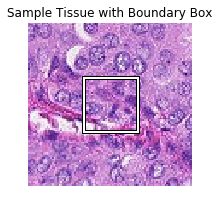

In [7]:
img = open_image(path/'Train/58b23975b1788da1ec68ea4b25f0b56d217700b0.tif') 
# returns an image object created from an image inside a filename
boundarybox = ImageBBox.create(img.size[0], img.size[1], bboxes=[[32, 32, 64, 64]]) # creates the boundary box object
img.show(y=boundarybox, title="Sample Tissue with Boundary Box") 
# image object function to plot the image overlaid with "y=boundarybox"
img.size # The size of the image

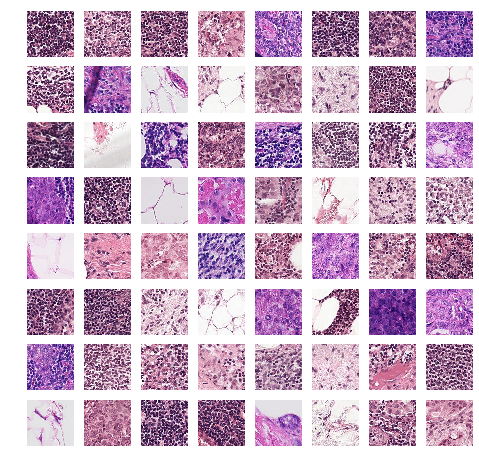

In [8]:
# Looking at more sample images
sample_images = random.sample(fnames, 64) # choosing 64 unique random images from the training set

imgs = []
for image in sample_images:
    file_path = os.path.join(path/'Train', image.parts[-1])
    im = open_image(file_path)
    imgs.append(im)

show_all(imgs, 8, 8, (8,8)) # Fastai command to show images by rows and figure size

### Now we'll plot the images and label them as positive or negative

In [14]:
from sklearn.utils import shuffle
from PIL import Image

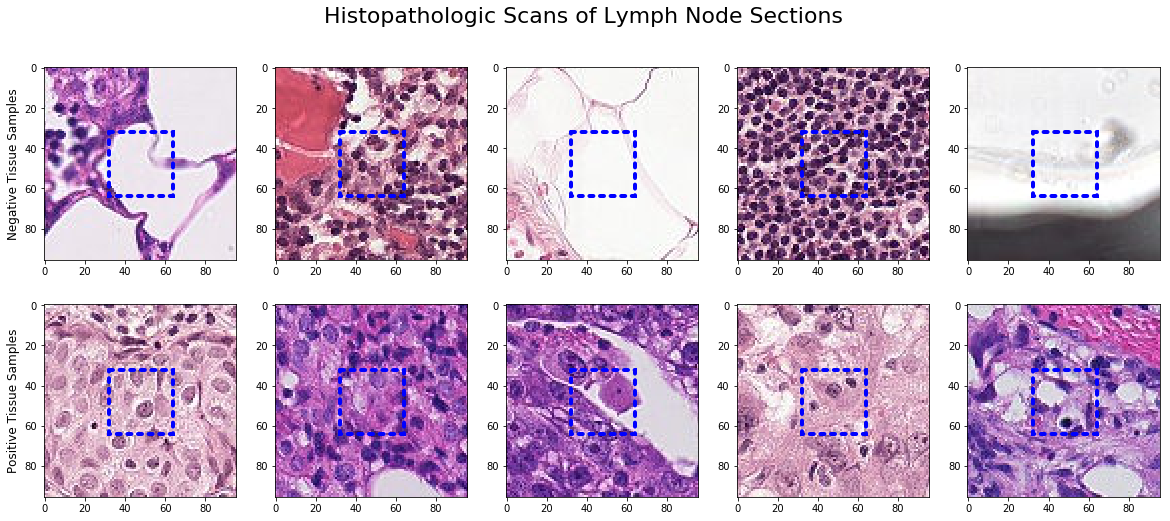

In [19]:
shuffled_images = shuffle(dftrain)

fig, ax = plt.subplots(2, 5, figsize=(20,8))
fig.suptitle('Histopathologic Scans of Lymph Node Sections', fontsize=22)
ax[1,0].set_ylabel('Positive Tissue Samples', size='large')
ax[0,0].set_ylabel('Negative Tissue Samples', size='large')

# Positive-labeled images
# Looping over 5 images from a shuffled set in the training set with labels = 1 (positive)
for i, idx in enumerate(shuffled_images[shuffled_images['label'] == 1]['id'][:5]):
    file_path = os.path.join(path/'Train', idx)
    im = Image.open(file_path + '.tif')
    ax[1,i].imshow(im)
    
    # Creating rectangular patches. Patches is a Matplotlib function
    bbox = patches.Rectangle((32,32), 32,32, linewidth=4, edgecolor='b',
                             facecolor='none', linestyle=':', capstyle='round')
    # adding the bounding box to the images
    ax[1,i].add_patch(bbox) 

# Negative-labeled images
# Looping over 5 images from a shuffled set in the training set with labels = 0 (negative)
for i, idx in enumerate(shuffled_images[shuffled_images['label'] == 0]['id'][:5]):
    file_path = os.path.join(path/'Train', idx)
    im = Image.open(file_path + '.tif')
    ax[0,i].imshow(im)
    
    bbox = patches.Rectangle((32,32), 32,32, linewidth=4, edgecolor='b',
                            facecolor='none', linestyle=':', capstyle='round')
    
    ax[0,i].add_patch(bbox)

## Creating a Databunch

A databunch is used to prepare the data so it can be trained using the fastai [Learner class](https://docs.fast.ai/basic_train.html#Learner).

### Data Augmentation

Data augmentation is technique used to increase the amount of training data by using information only in our training dataset. It can be used as a way we to reduce overfitting on models. Instead of feeding the model with the same pictures every time, we do small random transformations that don't change what's inside the image (for the human eye) but change its pixel values. Models trained with data augmentation will then generalize better.

We will flip the images horizontally, vertically, add a little bit of brightness, zoom and lighting. For more information on doing data augmentation with the fastai library, refer to [this link](https://docs.fast.ai/vision.transform.html#Data-augmentation).

In [4]:
tfms=get_transforms(do_flip=True, flip_vert=True, max_rotate=45, max_zoom=0.15,
               max_lighting=0.5, max_warp=0., p_affine=0.5, p_lighting=0.50)

### Defining The Validation Set

We will set the validation set to be 5% of the training set

In [5]:
# validation is 5% of the train set
valid_size = int(.05 *len(dftrain)) 
valid_size

11001

In [6]:
# validation index range
valid_idx = range((len(dftrain) - valid_size), len(dftrain))
valid_idx

range(209024, 220025)

### The Databunch

In [7]:
data = (ImageItemList.from_csv(path, 'train_labels.csv', folder='Train', suffix='.tif')
        .split_by_idx(valid_idx)  # validation set
        .label_from_df(columns='label') # the data is labeled from the train_labels.csv file
        .add_test_folder('Test') # specify the directroy where the test set images are located
        .transform(tfms, size=224) # data augmentation and image size of the transformations
        .databunch()
        .normalize(imagenet_stats)) # normalizing the data using the mean and the standard deviation

Now that the databunch is created, there are many functions that can be called from the object "data".

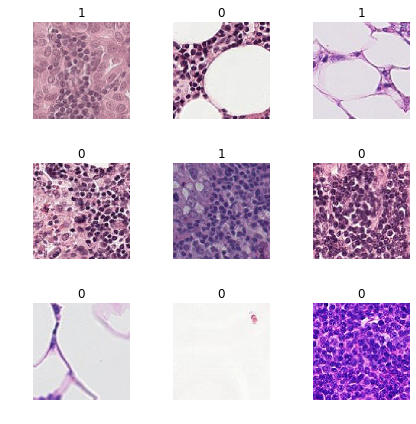

In [25]:
data.show_batch(rows=3, figsize=(6,6)) # shows a random batch of images from the dataset with their labels 

In [26]:
data.classes # shows what the classes are

[0, 1]

In [27]:
data.batch_size # shows the batch size. By default this number is 64

64

In [30]:
data.train_ds

LabelList
y: CategoryList (209024 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: Data/HCD
x: ImageItemList (209024 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: Data/HCD

In [31]:
data.valid_ds

LabelList
y: CategoryList (11001 items)
[Category 0, Category 0, Category 1, Category 0, Category 1]...
Path: Data/HCD
x: ImageItemList (11001 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: Data/HCD

In [32]:
data.test_ds

LabelList
y: CategoryList (57458 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: Data/HCD
x: ImageItemList (57458 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: Data/HCD

In [35]:
# Length of train, validation, and test sets
len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(209024, 11001, 57458)

## Training The Model

### Model architecture

To train this model we will use a technique called transfer learning where we will use a model trained on a very large dataset and then adapt it to our own dataset. Here we will use a pre-trained convolutional network model with ResNet 50 architecture. It comes pretrained from ImageNet so its weights have already been computed for us. It has already learned to recognize many features on all of its images, so we can benefit from this knowledge, instead of starting with a randomly initiliazed model.

In [8]:
arch = models.resnet50

In [44]:
# Here is what the ResNet 50 model architecture looks like
arch()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

The final layers (avgpool and fc) are replaced with new layers made specifically for our model.  Notice how the final layer fc here has out_features=1,000, which corresponds to 1,000 classes in Imagenet.  Our model will only have 2 classes. All the layers before the last 2 remain the same.  Their training information stays the same.

### Metrics

In [9]:
from sklearn.metrics import roc_auc_score
# the sklearn library has a function that calculates the area under the ROC curve

In [10]:
def auc_score(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1]))

In [11]:
metrics = [accuracy, auc_score]

### Training the model

In [12]:
wd=0.1 # weight decay

In [13]:
learn = create_cnn(data, arch=arch, metrics=metrics, wd=wd)

In [45]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

Notice the last layers in this model starting from AdaptiveConcatPool2d. They have replaced the last 2 layers in the ResNet 50 network.  You can also see that the last layer has out_features=2, which corresponds to the 2 classes we have.

In [46]:
learn.lr_find() 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


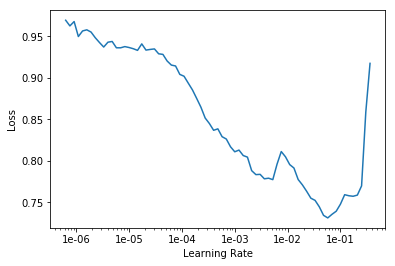

In [47]:
learn.recorder.plot() # We plot the learning rate vs loss to select the best value to train the model

In [49]:
lr=1e-2 # We want to select a learning rate that's on the downward slope, but not to close to the end of the slope.

In [50]:
# Now we train for 5 epochs
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,auc_score
1,0.214574,0.169072,0.936006,0.982477
2,0.177719,0.139814,0.950459,0.985624
3,0.157940,0.130150,0.954004,0.987729
4,0.123590,0.104669,0.964458,0.991711
5,0.132966,0.095601,0.968367,0.992460


In [51]:
learn.save('hcd-stage-1') # We save the model up to this point

### Fine Tuning

The model has achieved an accuracy of 96.8%, but this can be improved.  Previously, by default, the model was trained with its initial layers frozen. Now we will unfreeze all the layers in the model and train again.

In [19]:
learn.load('hcd-stage-1');

In [52]:
learn.unfreeze()

In [53]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


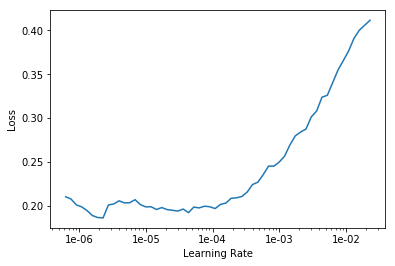

In [22]:
learn.recorder.plot()

In [54]:
doc(fit_one_cycle)

In [55]:
learn.fit_one_cycle(3, slice(1e-5,lr/10))

epoch,train_loss,valid_loss,accuracy,auc_score
1,0.147020,0.126718,0.955913,0.988199
2,0.119397,0.095718,0.967730,0.992917
3,0.087570,0.080145,0.972912,0.994723


In [56]:
learn.save('hcd-stage-2')

The accuracy a little to 97.2%. We will try it once more.

In [57]:
learn.load('hcd-stage-2');

In [58]:
learn.unfreeze()

In [59]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


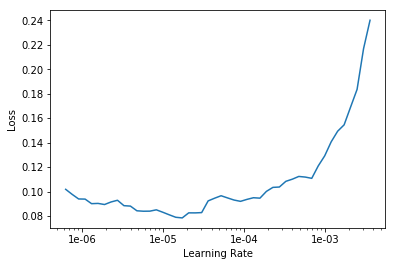

In [60]:
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(2, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,auc_score
1,0.090719,0.078748,0.973366,0.994900
2,0.093722,0.075200,0.975639,0.995333


In [62]:
learn.save('hcd-stage-3')

We'll run it once again to see if we can improve the accuracy and AUC score.

In [18]:
learn.load('hcd-stage-3');

In [19]:
learn.unfreeze()

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


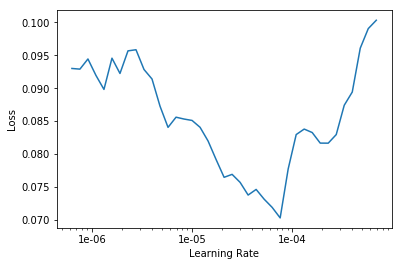

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(2, slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,auc_score
1,0.082385,0.075018,0.976366,0.995310
2,0.084545,0.074588,0.975002,0.995529


In [23]:
learn.save('hcd-stage-4')

It looks like the accuracy didn't imporve much so we'll stop here

In [ ]:
learn.load('hcd-stage-4');

# Model Classification Interpretation

We can see the confusion matrix and also plot the algorithms worse predictions of the validation set


In [24]:
inter = ClassificationInterpretation.from_learner(learn)

In [29]:
doc(inter.plot_top_losses)

## Plotting Top Losses

These are the images in the validation set that resulted with the highest loss after training. Above each image you'll see the predicted class (1 or 0), the actual class, the calculated loss, and the probability of the predicted class.

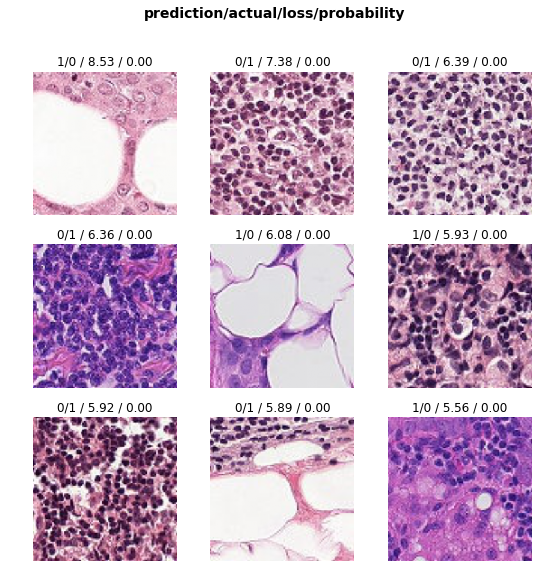

In [27]:
inter.plot_top_losses(9, figsize=(9,9))

## Confusion Matrix

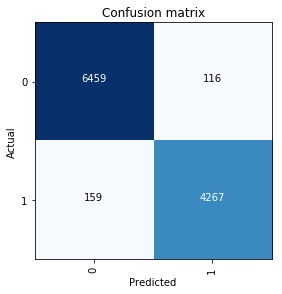

In [30]:
inter.plot_confusion_matrix()

# Predictions

In [32]:
# Test Time Augmentation
preds, test_labels = learn.TTA(ds_type=DatasetType.Test)

In [33]:
len(preds)

57458

In [35]:
# Creating a dataframe for the predictions in order to submit them
testdf = data.test_ds.to_df()
testdf.columns = ['id','label']
testdf['label'] = preds[:,1]
testdf['id'] = testdf['id'].apply(lambda fp: Path(fp).stem)
testdf.head()

,id,label
0,14b7966df72b115f7adfcf3eecd2ba1482691ed2,0.157784
1,221fd906e8eb4bce8fa6ac8f778dc53a6773a15a,0.069415
2,12ea9a4bdcd424dd5d6cd7b859c9583bef15b7e0,0.602393
3,943865c868a904087eac1c896ea166703184d95d,0.855023
4,154ab1ff17a7452b26adf570b0f728e1d38a785a,0.654372


The predictions are the probability that a class is either 0 or 1.

In [36]:
# Saving the predictions to a file
testdf.to_csv('submission36 - Kaggle - size=224.csv ', index=False)